In [1]:
# Helper function
import time

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func:{f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

# Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def func(X):
    x, y = X
    return x**4 - x**2 + y**2 + 2*x*y - 2

def first_derivative(X):
    x, y = X
    df_dx = 4*x**3 - 2*x + 2*y
    df_dy = 2*y + 2*x
    return np.array([df_dx, df_dy])

def second_derivative(X):
    x, y = X
    d2f_dx2 = 12*x**2 - 2
    d2f_dy2 = 2
    d2f_dxdy = 2
    d2f_dydx = 2
    return np.array([[d2f_dx2, d2f_dxdy], [d2f_dydx, d2f_dy2]])

## (a)

*For debugging*: new point should be $(0.15,0.9)$

In [3]:
original_point = np.array([1.5, 1.5])
step_size = 0.1
new_point = original_point - step_size*(first_derivative(original_point))

if func(new_point) < func(original_point):
    print("This is a good step")
else:
    print("This is a bad step")

This is a good step


## Description 
* After taking the initial optimization step from the starting point using the given step size, we evaluate the function value at the new point. If the function value has decreased, this indicates that we are moving towards a minimum (point converge); thus, the step is good. We might choose to keep the same step size or increase it slightly to maintain or accelerate the convergence pace(original step size*1.2).
* If the function value has increased, this is an indication that the step is not optimal. In this case, we would decrease the step size for the subsequent step(original step size*0.5). This careful reduction helps ensure that we are taking more conservative steps towards the minimum and helps to avoid passing over minima due to steps that are too large.

## (b)

*For debugging*: Take 41 steps to converge. Converge to point [-0.99999852,  0.99999607] with value -2.999999999985186.  took: 0.0020 sec

In [4]:
def steepest_descent(func, first_derivative, starting_point, step_size, tol):
    """
    Steepest Descent
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    
    Returns
    -------
    res: dict
        Optimization result
    """
    deriv = np.array(first_derivative(starting_point))
    count = 0
    visited = []
    while np.linalg.norm(deriv) > tol and count < 1e6:
        # calcualte new position
        new_point = starting_point - (step_size * deriv)
        if func(new_point) < func(starting_point):
            # the step makes function evaluation smaller - it is a good step. what do you do?
            step_size *= 1.2
            # Update the starting point for the next iteration
            starting_point = new_point
            # Record the path
            visited.append(new_point)
            # Update the derivative for the new point
            deriv = np.array(first_derivative(new_point))
        else:
            # the step makes function evaluation larger - it is a bad step. what do you do?
            step_size *= 0.5
            
        count += 1

    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited),
    }

Funtion for drawing path:

In [5]:
def draw_path(func, path, x_min=-2, x_max=2, y_min=-2, y_max=2):
    a = np.linspace(x_min, x_max, 100)
    b = np.linspace(y_min, y_max, 100)
    x, y = np.meshgrid(a, b)
    z = func((x, y))
    fig, ax = plt.subplots()
    contour = ax.contour(x, y, z, 50)
    plt.colorbar(contour)
    ax.plot(path[:, 0], path[:, 1], color='red')
    print("Length of the path:", len(path))

Length of the path: 41
Converge to point: [-0.99999852  0.99999607]


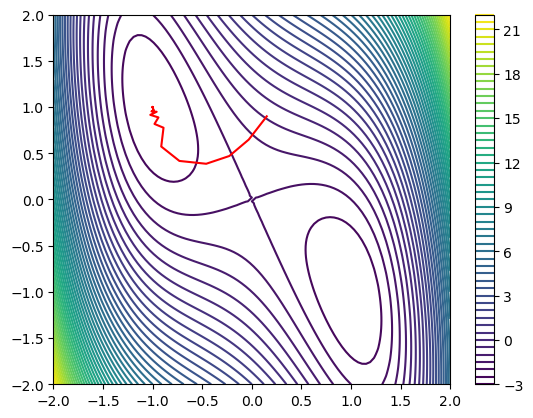

In [6]:
# optimization & draw path
res = steepest_descent(func, first_derivative, original_point, step_size, 1e-5)
draw_path(func, res["path"])
print("Converge to point:", res["x"])

## (c)

In [7]:
# CG/BFGS optimization with scipy
from scipy.optimize import minimize

# Perform CG optimization
res_cg = minimize(func, original_point, method='CG', jac=first_derivative, tol=1e-5)
print("CG optimization result:", res_cg)

# Perform BFGS optimization
res_bfgs = minimize(func, original_point, method='BFGS', jac=first_derivative, tol=1e-5)
print("BFGS optimization result:", res_bfgs)

CG optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.9999999999995746
       x: [-1.000e+00  1.000e+00]
     nit: 9
     jac: [ 1.914e-07 -1.126e-06]
    nfev: 26
    njev: 26
BFGS optimization result:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.9999999999998352
        x: [ 1.000e+00 -1.000e+00]
      nit: 7
      jac: [-1.631e-06 -6.808e-09]
 hess_inv: [[ 1.246e-01 -1.246e-01]
            [-1.246e-01  6.257e-01]]
     nfev: 8
     njev: 8


## Description 
#### Number of Steps: 
* Steepest Descent (SD): 41
* Conjugate Gradients (CG): 9 
* Broyden- Fletcher- Goldfarb- Shanno (BFGS): 7 
#### Both CG and BFGS are more efficient in terms of the number of steps needed to find the local minimum for the given function.

#### Reasons for efficiency:
* Direction of Descent: 
<br> Steepest Descent uses the negative gradient as the direction of descent which, although it is the direction of steepest decrease, might not be the most efficient path towards the minimum. 
<br> CG improves upon this by considering the history of gradients to avoid the inefficiencies of Steepest Descentâ€™s zig-zagging pattern. It ensures that each descent direction is conjugate to the others, providing a faster convergence.
<br> BFGS uses an approximation to the second derivative (Hessian), which provides curvature information allowing it to take more informed steps towards the minimum.

## Question 2

In [8]:
def Rosenbrock(X):
    x, y = X
    return (1 - x)**2 + 10*(y - x**2)**2

def Rosenbrock_grad(X):
    x, y = X
    df_dx = -2*(1 - x) - 40*x*(y - x**2)
    df_dy = 20*(y - x**2)
    return np.array([df_dx, df_dy])

## (a)

Length of the path: 1204
Converge to point: [0.99999089 0.99998153]


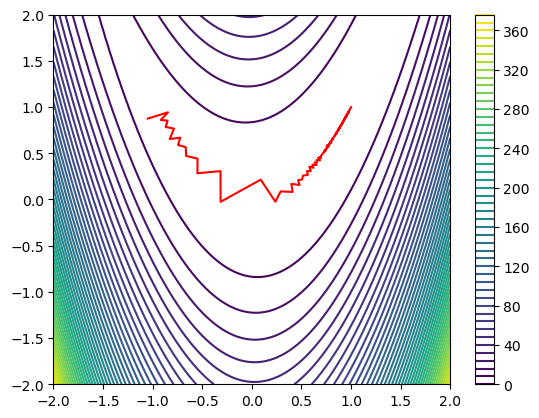

In [9]:
original_point = np.array([-0.5, 1.5])

# SD minimization & draw path
SD = steepest_descent(Rosenbrock, Rosenbrock_grad, original_point, step_size, 1e-5)
draw_path(Rosenbrock, SD["path"])
print("Converge to point:", SD["x"])

## (b)

In [10]:
#@timeit
def sgd(func, first_derivative, starting_point, step_size, tol, stochastic_injection=0):
    """
    Stochastic Gradient Descent
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    stochastic_injection: int
        Enable stochastic gradient (set to 1) or not (set to 0).
    
    Returns
    -------
    res: dict
        Optimization result
    """
    # evaluate the gradient of the starting point at first
    deriv = np.array(first_derivative(starting_point))
    count = 0
    visited = []
    while np.linalg.norm(deriv) > tol and count < 1e6:
        if stochastic_injection > 0:
            # formulate a stochastic_deriv (random vector) 
            # that is the same norm as your gradient 
            noise = 2 * np.random.random(len(deriv)) - 1
            noise_nor = noise / np.linalg.norm(noise) 
            stochastic_deriv = deriv+ noise_nor * np.linalg.norm(deriv)
        else:
            stochastic_deriv = np.zeros(len(starting_point))
        
        direction = -(deriv + stochastic_injection * stochastic_deriv)
        # new position
        new_point = starting_point + step_size * direction

        if func(new_point) < func(starting_point):
            # good step
            step_size *= 1.2
            
            # Update the visited list and the starting point
            visited.append(new_point)
            starting_point = new_point
            # evaluate the gradient for the new starting point
            deriv = np.array(first_derivative(starting_point))

        else:
            # bad step
            step_size *= 0.5
        count += 1
        
    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited)
    }

*For debugging*: This is a stochastic method so your outputs may vary. For SGD, it takes ~1700 steps to converge and it takes ~0.1 sec

Length of the path: 1029
Converge to point: [0.99998906 0.99997766]


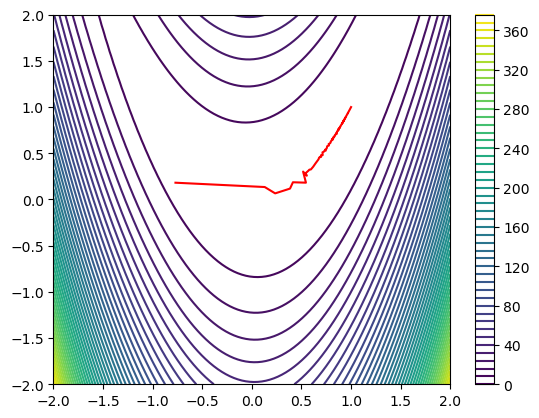

In [11]:
original_point = np.array([-0.5, 1.5])
stochastic_injection = 1
# SGD optimization and draw path
SGD = sgd(Rosenbrock, Rosenbrock_grad, original_point, step_size, 1e-5, stochastic_injection)
draw_path(Rosenbrock, SGD["path"])
print("Converge to point:", SGD["x"])

## (c)

In [12]:
# CG/BFGS with scipy

# Perform CG optimization
CG = minimize(Rosenbrock, original_point, method='CG', jac=Rosenbrock_grad, tol=1e-5)
print("CG optimization result:", CG)

# Perform BFGS optimization
BFGS = minimize(Rosenbrock, original_point, method='BFGS', jac=Rosenbrock_grad, tol=1e-5)
print("BFGS optimization result:", BFGS)

CG optimization result:  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.785157613112015e-14
       x: [ 1.000e+00  1.000e+00]
     nit: 19
     jac: [-9.630e-08 -1.905e-07]
    nfev: 42
    njev: 42
BFGS optimization result:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0004440848845513e-15
        x: [ 1.000e+00  1.000e+00]
      nit: 22
      jac: [ 1.152e-07 -1.292e-08]
 hess_inv: [[ 5.099e-01  1.020e+00]
            [ 1.020e+00  2.089e+00]]
     nfev: 31
     njev: 31


## Description 
#### Number of Steps: 
* Steepest Descent (SD): 1204
* Stochastic Gradient Descent (SGD): ~1000
* Conjugate Gradients (CG): 19 
* Broyden- Fletcher- Goldfarb- Shanno (BFGS): 22 

## (d
## Description
#### Drawing a firm conclusion about the performance of optimization algorithms based on just one run can be misleading due to several factors:
* Initial Conditions: 
<br> Optimization algorithms, especially non-convex ones, can be highly sensitive to the starting conditions. A single run might have started near a local minimum or in a particularly flat or steep region of the function, affecting the number of steps needed to converge.
* Stochastic Elements: 
<br> For methods that have stochastic components, like Stochastic Gradient Descent (SGD), results can vary between runs due to the random elements introduced. These methods typically require multiple runs to estimate their average performance.
* Hyperparameters: 
<br> The choice of hyperparameters (like step size or learning rate) can have a substantial effect on the performance. A single run might not be representative if these were not optimally chosen.
#### To draw a firm conclusion, we would perform multiple runs with different starting points(2e) and hyperparameters, and then statistically analyze the results to understand the average performance and its variance. Only then can we reliably compare the efficiency and effectiveness of different optimization methods for a given problem.

## (e)

In [13]:
def statistics_test(method, args, times, global_minimum=None):
    result = []
    for n in range(times):
        res = method(*args)
        
        # If the norm of the differnce vector between the global minimum
        # and the resulting point is larger than 1e-3, the point will not
        # be considered as a global minimum
        if (global_minimum is not None) and (np.linalg.norm(res["x"] - global_minimum) > 1e-3):
            continue
        result.append(len(res["path"]))
        print("    Converge to point:", res["x"])
        print("    Length of the path:", len(res["path"]))
    msg = f"Running {times} times: reach global minimum {len(result)} times"
    if len(result) > 0:
        avg = np.mean(result) # calculate the average
        std = np.std(result) # calculate the standard deviation
        msg += f", average {int(avg)} steps with variance {std:.2f}\n"
    print(msg)

    
starting_points = [
    original_point,
    np.array([0.0, 1.0]),
    np.array([-1.0, 1.0]),
    np.array([1.5, 0.5])
]

In [14]:
# test different minimization algorithms for different starting points
original_point = np.array([-0.5, 1.5])
global_minimum = np.array([1.0, 1.0])
stochastic_injection = 1
for point in starting_points:
    print(f"Testing from starting point: {point}")
    
    # Non-stochastic Method
    # SD
    SD_2e = steepest_descent(Rosenbrock, Rosenbrock_grad, point, step_size, 1e-5)
    print(f"SD optimization result:")
    print(f"    Converge to point:", SD_2e["x"])
    print(f"    Length of the path:", len(SD_2e["path"]))
    # CG
    CG_2e = minimize(Rosenbrock, point, method='CG', jac=Rosenbrock_grad, tol=1e-5)
    print(f"CG optimization result:")
    print(f"    Converge to point:", CG_2e["x"])
    print(f"    Length of the path:", CG_2e["nit"])
    # BFGS
    BFGS_2e = minimize(Rosenbrock, point, method='BFGS', jac=Rosenbrock_grad, tol=1e-5)
    print(f"BFGS optimization result:")
    print(f"    Converge to point:", BFGS_2e["x"])
    print(f"    Length of the path:", BFGS_2e["nit"])
    
    # Stochastic Method
    # SGD test
    print(f"SGD optimization result:")
    statistics_test(sgd, (Rosenbrock, Rosenbrock_grad, original_point, step_size, 1e-5, stochastic_injection), 10, global_minimum)    

Testing from starting point: [-0.5  1.5]
SD optimization result:
    Converge to point: [0.99999089 0.99998153]
    Length of the path: 1204
CG optimization result:
    Converge to point: [0.99999976 0.99999951]
    Length of the path: 19
BFGS optimization result:
    Converge to point: [1.00000004 1.00000009]
    Length of the path: 22
SGD optimization result:
    Converge to point: [0.99998946 0.99997848]
    Length of the path: 1112
    Converge to point: [0.99998908 0.99997776]
    Length of the path: 1092
    Converge to point: [1.00001068 1.00002179]
    Length of the path: 992
    Converge to point: [0.99998948 0.99997853]
    Length of the path: 1068
    Converge to point: [0.99998986 0.99997939]
    Length of the path: 1124
    Converge to point: [0.99998915 0.99997789]
    Length of the path: 1078
    Converge to point: [0.99998948 0.9999785 ]
    Length of the path: 1126
    Converge to point: [0.99998973 0.99997897]
    Length of the path: 1096
    Converge to point: [0.999

## Description 
#### Number of Steps for Different Starting Points: 
* Non-stochastic Methods v.s. Stochastic Methods
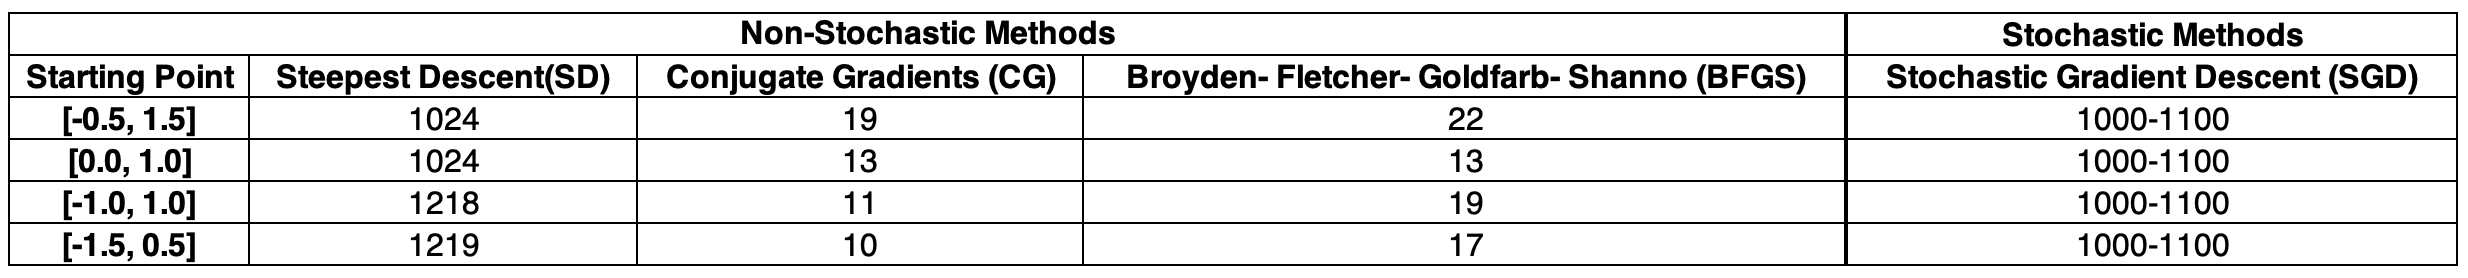

* For different starting points, different algorithms do not have much difference.
* Stochastic Gradient Descent exhibits variable performance. While it does reach the global minimum consistently, the number of steps it takes has a wide range. The stochastic nature of the method introduces variability, which can sometimes lead to faster convergence if the random perturbations help escape shallow local minima or traverse narrow valleys more effectively. <br> However, this can also lead to less efficient paths due to the randomness, as seen by the high variance in the number of steps. On average, SGD requires more steps than CG and BFGS, indicating that while it can be robust against getting trapped in local minima, it is generally less efficient for complex landscapes like the Rosenbrock Banana Function.

# Question 3

In [15]:
def Camel(X):
    x, y = X
    return 2*x**2 - 1.05*x**4 + x**6/6 + x*y + y**2

def Camel_grad(X):
    x, y = X
    df_dx = 4*x - 4.2*x**3 + x**5 + y
    df_dy = x + 2*y
    return np.array([df_dx, df_dy])

## (a)

In [16]:
original_point = np.array([-1.5, -1.5])
step_size = 0.1
stochastic_injection = 1

starting_points = [
    original_point,
    np.array([0.0, 1.0]),
    np.array([-1.0, 1.0]),
    np.array([1.5, 0.5])
]

Length of the path: 36
Converge to point: [ 1.7475525 -0.8737742]


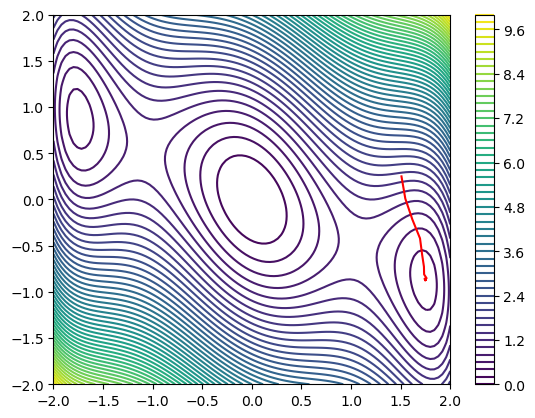

In [17]:
# SD optimization and draw path
SD_3a = steepest_descent(Camel, Camel_grad, point, step_size, 1e-5)
draw_path(Camel, SD_3a["path"])
print("Converge to point:", SD_3a["x"])

## Description 
#### Steepest Descent (SD)
A first-order optimization algorithm that uses the gradient of the function to guide its search for a minimum. In the context of functions with multiple minima, such as the Three-Hump Camel function, the SD algorithm can fall into local minima due to its inherent approach:
* Local Information: SD uses only local gradient information to determine the direction of the next step. If the gradient points towards a local minimum, the algorithm will follow that path, potentially leading to convergence at that local minimum.
* Lack of Momentum: Unlike methods that incorporate momentum or adaptive step sizes, SD does not 'remember' past gradients. This means it can't accumulate knowledge that might help it escape local minima or traverse narrow valleys more efficiently.
* Path Dependence: The path taken by SD is heavily dependent on the starting point. If the starting point is closer to a local minimum than to the global minimum, the algorithm is more likely to converge to that local minimum.

Length of the path: 33
Converge to point: [-1.74755237  0.87377357]


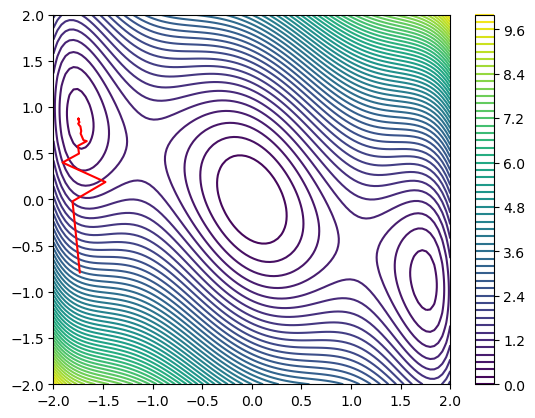

In [18]:
# SGD optimization and draw path
SGD_3a = sgd(Camel, Camel_grad, original_point, step_size, 1e-5, stochastic_injection)
draw_path(Camel, SGD_3a["path"])
print("Converge to point:", SGD_3a["x"])

In [19]:
# test different minimization algorithms for different starting points

global_minimum = np.array([0.0, 0.0])
stochastic_injection = 1

for point in starting_points:
    print(f"Testing from starting point: {point}")
    
    # Non-stochastic Method
    # SD
    SD_3a = steepest_descent(Camel, Camel_grad, point, step_size, 1e-5)
    print(f"SD optimization result:")
    print(f"    Converge to point:", SD_3a["x"])
    print(f"    Length of the path:", len(SD_3a["path"]))
    # CG
    CG_3a = minimize(Camel, point, method='CG', jac=Camel_grad, tol=1e-5)
    print(f"CG optimization result:")
    print(f"    Converge to point:", CG_3a["x"])
    print(f"    Length of the path:", CG_3a["nit"])
    # BFGS
    BFGS_3a = minimize(Camel, point, method='BFGS', jac=Camel_grad, tol=1e-5)
    print(f"BFGS optimization result:")
    print(f"    Converge to point:", BFGS_3a["x"])
    print(f"    Length of the path:", BFGS_3a["nit"])
    
    # Stochastic Method
    # SGD test
    print(f"SGD optimization result:")
    statistics_test(sgd, (Camel, Camel_grad, original_point, step_size, 1e-5, stochastic_injection), 10, global_minimum)

Testing from starting point: [-1.5 -1.5]
SD optimization result:
    Converge to point: [-1.74755157  0.87377203]
    Length of the path: 36
CG optimization result:
    Converge to point: [-1.74755166  0.8737762 ]
    Length of the path: 7
BFGS optimization result:
    Converge to point: [-1.74755233  0.87377616]
    Length of the path: 8
SGD optimization result:
    Converge to point: [-2.11296477e-06  2.65489686e-06]
    Length of the path: 18
    Converge to point: [ 9.02664206e-07 -8.44437256e-07]
    Length of the path: 20
    Converge to point: [-2.79672538e-07  2.59070831e-06]
    Length of the path: 17
    Converge to point: [ 9.3861161e-07 -8.2683306e-07]
    Length of the path: 20
Running 10 times: reach global minimum 4 times, average 18 steps with variance 1.30

Testing from starting point: [0. 1.]
SD optimization result:
    Converge to point: [-2.00309632e-06 -3.34438492e-07]
    Length of the path: 16
CG optimization result:
    Converge to point: [ 2.86004005e-08 -4.626

## Description 
#### Number of Steps for Different Starting Points: 
* SD, CG, and BFGS Algorithms
<br> For SD, CG, and BFGS Algorithms, they only converge to the global minimum when starting at point [0.0, 1.0], rest of point, just fall into local minima. 
* SGD Algorithms
<br> Although I set up the SGD algorithm to run ten times and it didn't converge to the global minimum every time, I was at least able to make sure that I could find the global minimum from different starting points. 


## (b)

*For debugging*: This is a stochastic method so your outputs may vary. For SGDM, it takes ~200 steps to converge and it takes ~0.02 sec

In [20]:
@timeit
def sgdm(func, first_derivative, starting_point, step_size, tol, stochastic_injection=0, momentum=0):
    """
    Stochastic Gradient Descent with Momentum
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    stochastic_injection: int
        Enable stochastic gradient (set to 1) or not (set to 0).
    momentum: float
        Momentum (\eta) value in SGDM algorithm
    
    Returns
    -------
    res: dict
        Optimization result
    """
    
    deriv = first_derivative(starting_point)
    count = 0
    visited = []
    previous_direction = np.zeros(len(starting_point))
    while np.linalg.norm(deriv) > tol and count < 1e6:
        if stochastic_injection > 0:
            # formulate a stochastic_deriv (random vector) 
            # that is the same norm as your gradient 
            noise = 2 * np.random.random(len(deriv)) - 1
            noise_nor = noise / np.linalg.norm(noise) 
            stochastic_deriv = deriv + noise_nor * np.linalg.norm(deriv)
        else:
            stochastic_deriv = np.zeros(len(starting_point))
        
        # new direction 
        direction = -(deriv + stochastic_injection * stochastic_deriv)
        # calculate new point, don't forget momentum!
        new_point = starting_point + step_size * (direction + (momentum * previous_direction))
        previous_direction = direction

        if func(new_point) < func(starting_point):
            # good step
            step_size *= 1.2
            
            # Update the visited list and the starting point
            visited.append(new_point)
            starting_point = new_point
            # evaluate the gradient for the new starting point
            deriv = np.array(first_derivative(starting_point))
        else:
            # bad step
            if step_size < 1e-5:
                # step size too small, zero out the previous direction
                # since we know it is a bad direction
                previous_direction = np.zeros(len(starting_point))
            else:
                step_size *= 0.5
        count += 1
    
    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited)
    }

func:sgdm took: 0.0055 sec
Length of the path: 24
Converge to point: [-8.09635541e-07  2.75474071e-07]


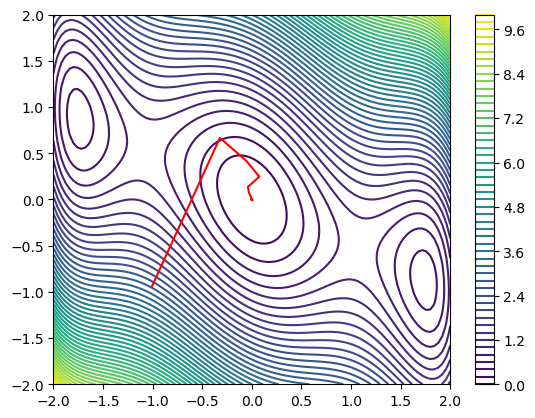

In [25]:
# test SDGM
original_point = np.array([-1.5, -1.5])
stochastic_injection = 1
momentum = 0.9

# SDGM optimization and draw path
SDGM = sgdm(Camel, Camel_grad, original_point, step_size, 1e-5, stochastic_injection, momentum)
draw_path(Camel, SDGM["path"])
print("Converge to point:", SDGM["x"])

## Description 
The advantage of SGDM over SGD, CG, and BFGS lies in its use of momentum, which helps accelerate the descent in the correct direction and can prevent the oscillations or zigzagging that are common with SGD, CG, and BFGS. This can make SGDM more efficient and precise than SGD, CG, and BFGS, especially in terms of consistently reaching the global minimum with fewer steps.
